Key things to do:
- make plt.imshow() plots over a grid of baselines from -50 to +50 m in x and y
- with a single point source, look at visibility as a function baseline vector, both real/imag and abs/angle
- try varying point source position, try varying the frequency
- try adding multiple sources with same/different flux
- bonus: try doing a 2D FFT of your grid
- pick frequency between 100 and 200 MHz
- start with "unit beam" = 1
- can also try Gaussian beam with some scale width from the zenith

- vectorizing calculations in numpy (put things in numpy arrays rather than just lists)
- use docstrings
- use shift tab
- learn np.meshgrid, for real this time


(10201,)


<IPython.core.display.Javascript object>


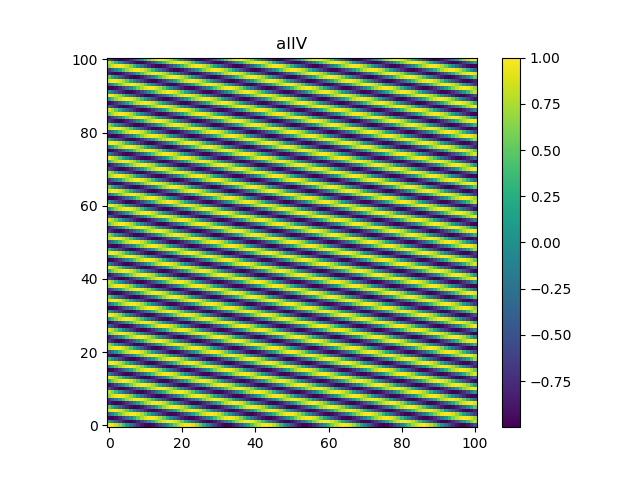

In [88]:
import numpy as np
def Vsimple(nu, b, r):
    ''' frequency in Hz
     normalizes r vector
     '''
    c = 3*10**8
    flux = 1
    r = r/np.linalg.norm(r)
    return flux*np.exp(-2*np.pi*1j*(nu/c)*np.dot(b,r))

# np.linalg.norm(r) gives us the magnitude of the vector, and to normalize we divide it through like this:
# where "r /= a" is really "r = r/a"
### Interesting issue: using r /= a causes issues for many values of components for r, when r is an array

rtest = np.array([0.2, 1, 1])

# Vsimple(1e8, b, r)
# freqs = np.linspace(1e8, 2e8, 100)
# Vsimple(freqs, b, r)

baselines = np.array(np.meshgrid(np.arange(-50,51), np.arange(-50,51), [0]))
baselines = baselines.reshape(3,-1).T

allV = np.array([Vsimple(1e8, b, rtest) for b in baselines]).reshape(101,101)

%matplotlib notebook
plt.figure()
plt.title("allV")
plt.imshow(allV.real,origin='lower')
plt.colorbar()

plt.show()



<IPython.core.display.Javascript object>


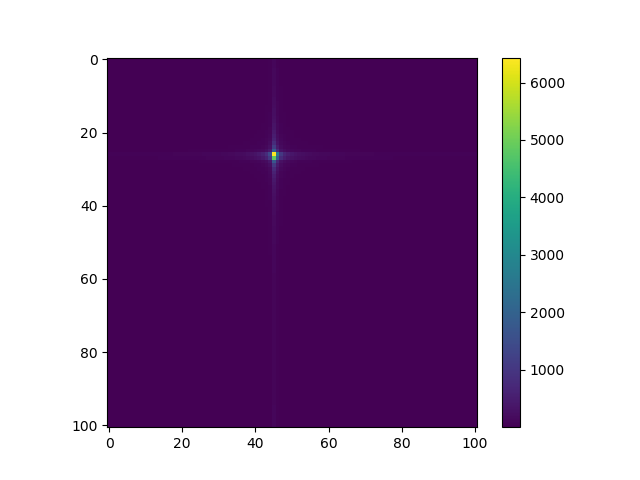

In [46]:
plt.figure()
# should just memorize this line for FFT
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(allV))))
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


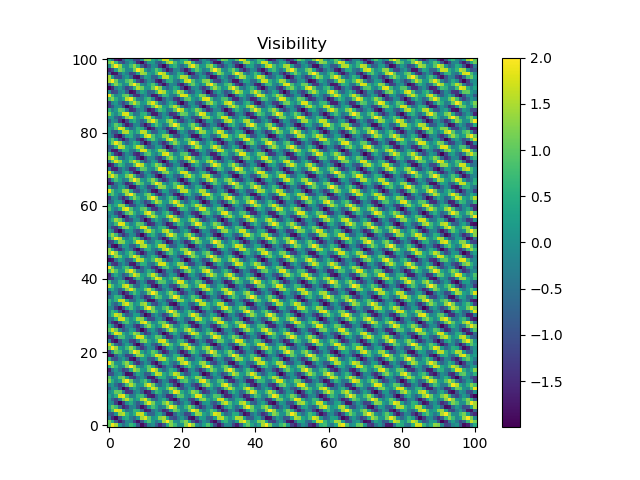

<IPython.core.display.Javascript object>


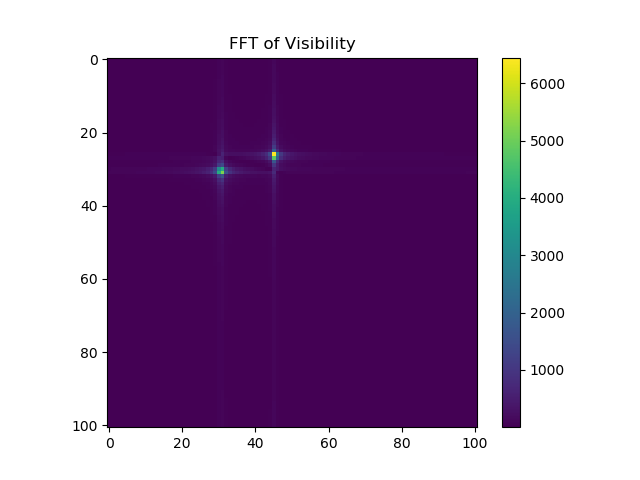

In [84]:
# Visibility as the result of 2 point sources

rtest2 = np.array([1, 1, 1])
allV2 = allV + np.array([Vsimple(1e8, b, rtest2) for b in baselines]).reshape(101,101)

plt.figure()
plt.title("Visibility")
plt.imshow(allV2.real,origin='lower')
plt.colorbar()


plt.figure()
plt.title("FFT of Visibility")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(allV2))))
plt.colorbar()
plt.show()



In [56]:
def filters(bl):
    '''Input grid of baselines (bl)
    and filter out redundancies'''
    filtered = []
    norms = []
    for b in bl:
        if np.linalg.norm(b) not in norms:
            norms.append(np.linalg.norm(b))
            filtered.append(b)
    return np.array(filtered)

### At this point I realize it doesn't make sense filter out redundancies unless I'm able to make a corresponding grid,
### which requires the square root of the total number of elements to be an integer. 

# print(baselines)
# b2 = filters(baselines)
# print(baselines.shape)
# print(b2)
# print(b2.shape)

# filteredV = np.array([Vsimple(1e8, b, r) for b in b2]).reshape(56,56)

# %matplotlib notebook
# plt.imshow(filteredV.real,origin='lower')
# plt.colorbar()
# plt.show()

In [121]:
# Gaussian Beam: formula taken from "Gaussian Beam" Wikipedia page
def Gbeam(ax,rad,freq):
    
    '''ax is the axial distance from the source
    rad is the radial distance from the source
    freq is the frequency in Hz 
    Note: w_0 = 1, E_0 = 1 for simplicity'''
    
    w_0 = 1
    E_0 = 1
    c = 3*(10**8)
    k = 2*np.pi*freq/c
    # factor = z/z_R = expression that comes up pretty often throughout the equation
    # note that factor is not a constant; it's dependent on both axial distance and frequency
    factor = ax*c/(np.pi*(w_0**2)*freq)
    w = np.sqrt(1 + (factor)**2)
    R = ax*(1 + (1/factor)**2)
    psi = np.arctan(factor)
    
    return E_0*(1/w)*np.exp(-(rad**2)/(w**2))*np.exp(-1j*(k*ax + k*(rad**2)/(2*R) - psi))

# Now, define a new function for visibility that uses the Gaussian beam:
def VGbeam(freq, b, r):
    '''freq in Hz
    r = position of one source; will be normalized
    b = set of baseline vectors'''
    c = 3*10**8
    # S is the flux of the source, which will still be set to 1
    S = 1
    # I think because Gbeam uses axial and radial distances, axial is just the z component of r:
    raxial = r[2]
    rhat = r/np.linalg.norm(r)
    bmags = np.array([np.linalg.norm(baseline) for baseline in b])
    return S*Gbeam(raxial,bmags,freq)*np.exp(-2*np.pi*1j*(nu/c)*np.dot(b,r))
    
rtest = np.array([0.2, 1, 1])
baselines = np.array(np.meshgrid(np.arange(-50,51), np.arange(-50,51), [0]))
baselines = baselines.reshape(3,-1).T

allVG = np.array([VGbeam(1e8, b, rtest) for b in baselines]).reshape(101,101)


ValueError: cannot reshape array of size 30603 into shape (101,101)

In [119]:
print(baselines)
bmags = np.array([np.linalg.norm(baseline) for baseline in baselines])
print(bmags)

[[-50 -50   0]
 [-49 -50   0]
 [-48 -50   0]
 ...
 [ 48  50   0]
 [ 49  50   0]
 [ 50  50   0]]
[70.71067812 70.00714249 69.3108938  ... 69.3108938  70.00714249
 70.71067812]


In [68]:
def Vsimple(nu, b, r):
    ''' frequency in Hz
     normalizes r vector
     '''
    c = 3*10**8
    flux = 1
    r /= np.linalg.norm(r)
    return flux*np.exp(-2*np.pi*1j*(nu/c)*np.dot(b,r))